In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from bqplot import pyplot as plt
#from bqplot import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
sns.set()

### Load data
The usual.

In [4]:
df = pd.read_csv('data/cycles-with-features.csv', header=0).drop(labels='Unnamed: 0', axis=1)
df = df[df.Cycle >= 1].reset_index().drop('index', axis=1)

# Curve fitting
Now on piecewise components of each cycle.

### Polynomial curve fit
Curve fit on increasing slope.

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
w, h = 12, 8

Select increasing-load side of each cycle.

In [6]:
c=25 # for example
start = df[(df.Cycle==c) & (df.Min==1)].index.values[0]
peak = df[(df.Cycle==c) & (df.Max==1)].index.values[0]+1
inc = df[df.Cycle==c].iloc[:(peak-start)]

In [7]:
X = inc.drop(['Load', 'Datetime'], axis=1).fillna(0)
y = inc.Load
model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X, y)
yh = model.predict(X)

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


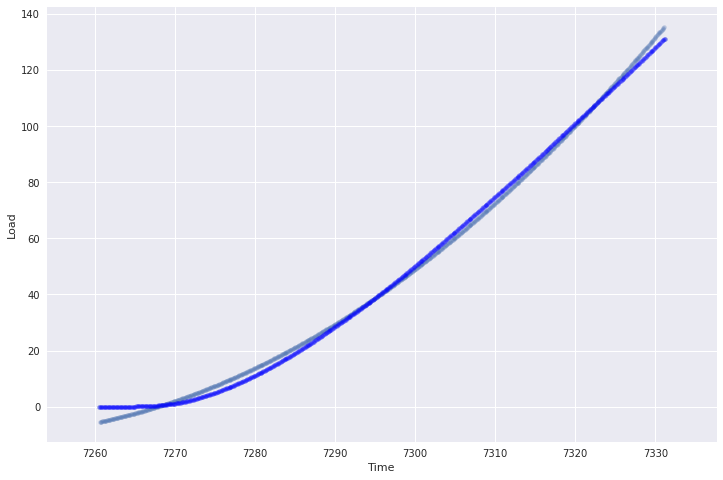

In [8]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot(X.Time, yh, fit_reg=False, ax=ax, scatter_kws={'s': 20, 'alpha': 0.3})
sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})

In [9]:
np.sqrt(mse(yh, y))

2.0351358557326518

### Clustering and multiple regression
Not good enough. Let's try subdividing the heating portion of each cycle using clustering.

In [10]:
from sklearn.cluster import KMeans

In [11]:
km = KMeans(n_clusters=2).fit(inc[['Time', 'Load']])
c = km.fit_predict(inc[['Time', 'Load']])
c0 = inc[np.logical_not(c)]
c1 = inc[c.astype(bool)];

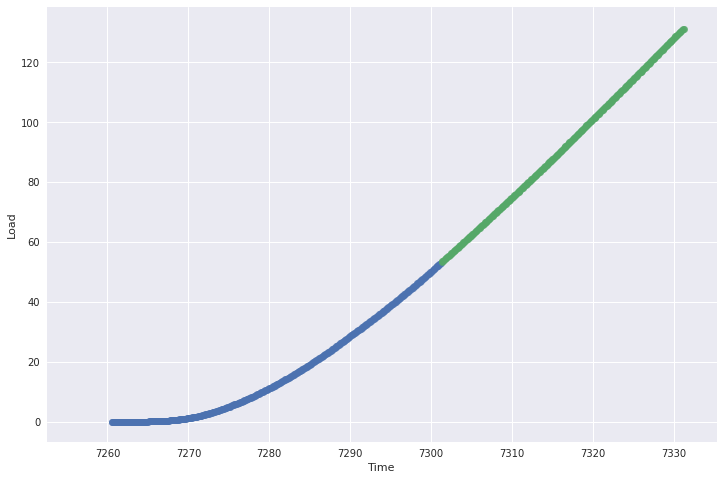

In [12]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot('Time', 'Load', c0, fit_reg=False, ax=ax)
sns.regplot('Time', 'Load', c1, fit_reg=False, ax=ax)
#sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 20, 'alpha': 0.2})

Now we fit curves to each cluster.

In [13]:
X0 = c0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1 = c1.drop(['Load', 'Datetime'], axis=1).fillna(0)
y0 = c0.Load; y1 = c1.Load
model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X0, y0); yh0 = model.predict(X0)
model.fit(X1, y1); yh1 = model.predict(X1)

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


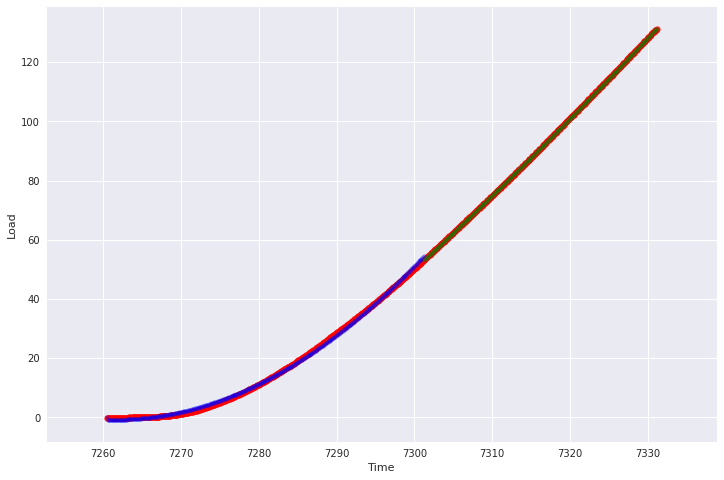

In [14]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 40, 'alpha': 0.8})
sns.regplot(X0.Time, yh0, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
sns.regplot(X1.Time, yh1, fit_reg=False, ax=ax, scatter_kws={'color': 'green', 's': 20, 'alpha': 0.3})

Error is much better (less), but we have to deal with a discontinuity between clusters now.

In [80]:
np.sqrt(mse(yh0, y0)), np.sqrt(mse(yh1, y1))

(0.594636990360478, 0.067667266713464)

Now for all cycles.

In [96]:
import warnings
warnings.simplefilter("ignore", UserWarning)

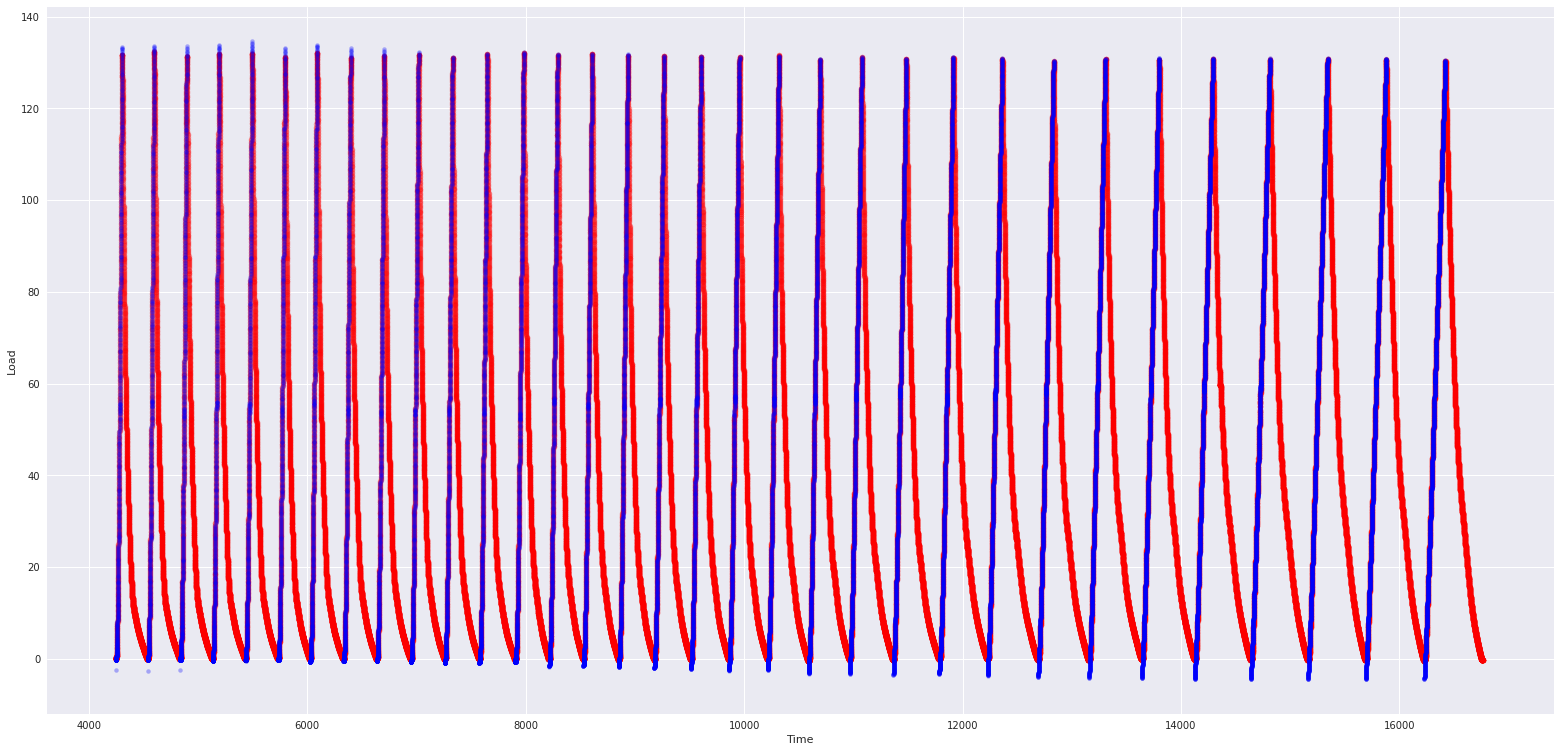

In [109]:
fig, ax = plt.subplots(figsize=(w+15,h+5))
rmses = []
df = df[df.Cycle > 14]
for c in np.nditer(df.Cycle.unique()):
    # delimit cycles
    start = df[(df.Cycle==c) & (df.Min==1)].index.values[0]
    peak = df[(df.Cycle==c) & (df.Max==1)].index.values[0]+1
    inc = df[df.Cycle==c].iloc[:(peak-start)]
    
    # cluster cycle
    km = KMeans(n_clusters=2).fit(inc[['Time', 'Load']])
    ch = km.fit_predict(inc[['Time', 'Load']])
    c0 = inc[np.logical_not(ch)]
    c1 = inc[ch.astype(bool)];
    
    # fit curve-before- and curve-after- knee
    X0 = c0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1 = c1.drop(['Load', 'Datetime'], axis=1).fillna(0)
    y0 = c0.Load; y1 = c1.Load
    model = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(X0, y0); yh0 = model.predict(X0)
    model.fit(X1, y1); yh1 = model.predict(X1)
    
    X = df[df.Cycle==c]
    sns.regplot(X.Time, X.Load, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 30, 'alpha': 0.3})
    sns.regplot(X0.Time, yh0, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    sns.regplot(X1.Time, yh1, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    rmses.append((np.sqrt(mse(yh0, y0)), np.sqrt(mse(yh1, y1))))

Now the same for the decreasing (cooling) side.

In [142]:
c=25 # for example
peak = df[(df.Cycle==c) & (df.Max==1)].index.values[0]+1
start = df[(df.Cycle==c) & (df.Min==1)].index.values[0]
end = df[df.Cycle==c].tail(1).index.values[0]
dec = df[df.Cycle==c].iloc[(peak-start):(end-start)]

In [143]:
X = dec.drop(['Load', 'Datetime'], axis=1).fillna(0)
y = dec.Load
model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X, y)
yh = model.predict(X)

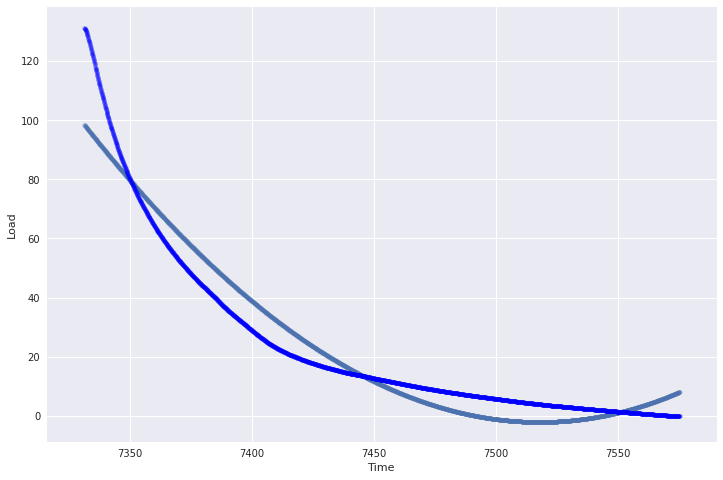

In [144]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot(X.Time, yh, fit_reg=False, ax=ax, scatter_kws={'s': 20, 'alpha': 0.3})
sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})

Clearly not so great - we try clustering again.

In [154]:
km = KMeans(n_clusters=2).fit(dec[['Time', 'Load']])
c = km.fit_predict(dec[['Time', 'Load']])
c0 = dec[np.logical_not(c)]
c1 = dec[c.astype(bool)];

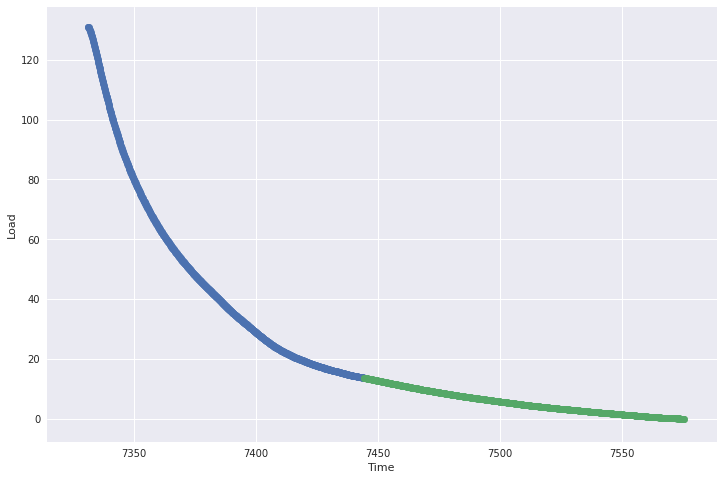

In [155]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot('Time', 'Load', c0, fit_reg=False, ax=ax)
sns.regplot('Time', 'Load', c1, fit_reg=False, ax=ax)

In [15]:
X0 = c0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1 = c1.drop(['Load', 'Datetime'], axis=1).fillna(0)
y0 = c0.Load; y1 = c1.Load
model = make_pipeline(PolynomialFeatures(3), Ridge())
model.fit(X0, y0); yh0 = model.predict(X0)
model.fit(X1, y1); yh1 = model.predict(X1)

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


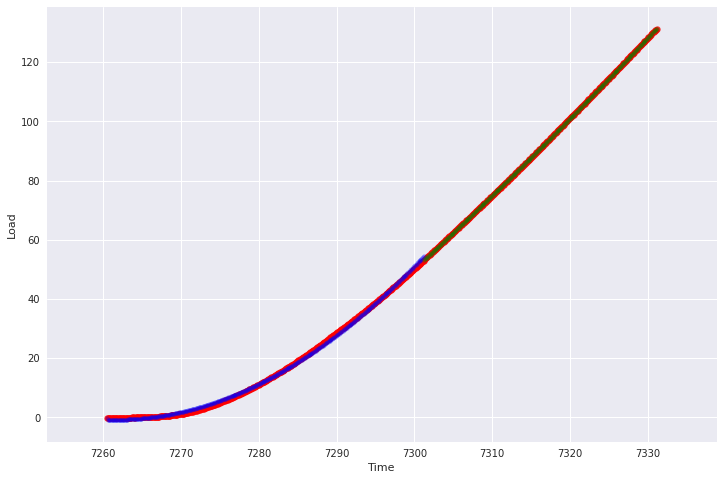

In [16]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 40, 'alpha': 0.8})
sns.regplot(X0.Time, yh0, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
sns.regplot(X1.Time, yh1, fit_reg=False, ax=ax, scatter_kws={'color': 'green', 's': 20, 'alpha': 0.3})

Not bad, even with just a 3rd-degree polynomial fit.

In [17]:
np.sqrt(mse(yh0, y0)), np.sqrt(mse(yh1, y1))

(0.5838044880596578, 0.06743280052232223)

Putting it all together (no inference).

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2969575169290297e-22 / 1.1102230246251565e-16
  RuntimeWarning)
/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.014103

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4098335633105748e-23 / 1.1102230246251565e-16
  RuntimeWarning)
/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.167978

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1351308790429745e-23 / 1.1102230246251565e-16
  RuntimeWarning)
/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.875889

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.145576006231911e-25 / 1.1102230246251565e-16
  RuntimeWarning)
/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0357314

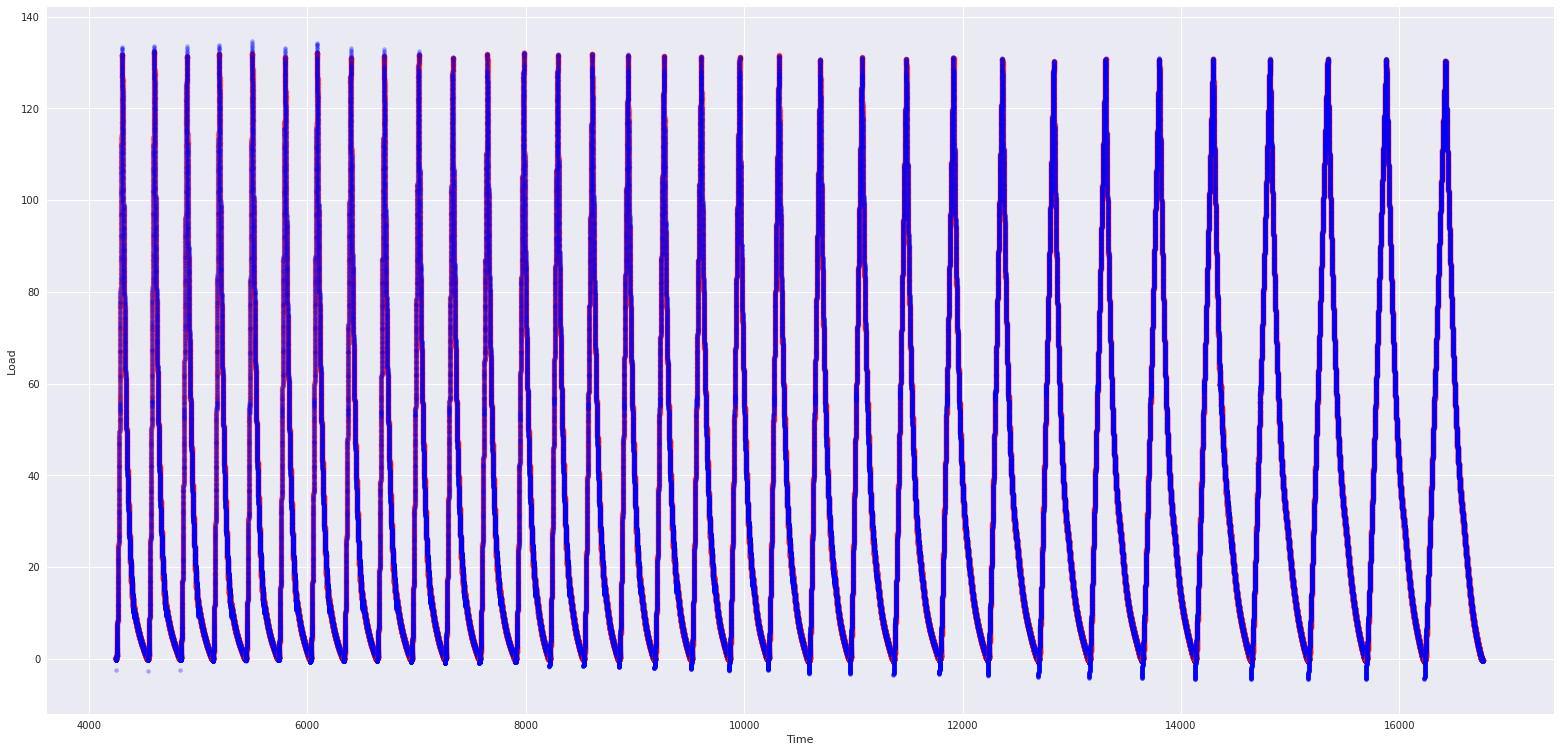

In [18]:
fig, ax = plt.subplots(figsize=(w+15,h+5))
rmses = []
df = df[df.Cycle > 14]
for c in np.nditer(df.Cycle.unique()):
    # delimit cycles
    start = df[(df.Cycle==c) & (df.Min==1)].index.values[0]
    peak = df[(df.Cycle==c) & (df.Max==1)].index.values[0]+1
    inc = df[df.Cycle==c].iloc[:(peak-start)]
    end = df[df.Cycle==c].tail(1).index.values[0]
    dec = df[df.Cycle==c].iloc[(peak-start):(end-start)]
    
    # cluster cycle, increasing
    km = KMeans(n_clusters=2).fit(inc[['Time', 'Load']])
    ch = km.fit_predict(inc[['Time', 'Load']])
    ic0 = inc[np.logical_not(ch)]
    ic1 = inc[ch.astype(bool)];
    
    # cluster cycle, decreasing
    km = KMeans(n_clusters=2).fit(dec[['Time', 'Load']])
    ch = km.fit_predict(dec[['Time', 'Load']])
    dc0 = dec[np.logical_not(ch)]
    dc1 = dec[ch.astype(bool)];
    
    # fit curve-before- and curve-after- knee, increasing
    X0i = ic0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1i = ic1.drop(['Load', 'Datetime'], axis=1).fillna(0)
    y0i = ic0.Load; y1i = ic1.Load
    model = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(X0i, y0i); yh0i = model.predict(X0i)
    model.fit(X1i, y1i); yh1i = model.predict(X1i)
    
    # fit curve-before and curve-after- knee, decreasing
    X0d = dc0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1d = dc1.drop(['Load', 'Datetime'], axis=1).fillna(0)
    y0d = dc0.Load; y1d = dc1.Load
    model = make_pipeline(PolynomialFeatures(3), Ridge())
    model.fit(X0d, y0d); yh0d = model.predict(X0d)
    model.fit(X1d, y1d); yh1d = model.predict(X1d)
    
    X = df[df.Cycle==c]
    sns.regplot(X.Time, X.Load, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 30, 'alpha': 0.3})
    sns.regplot(X0i.Time, yh0i, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    sns.regplot(X1i.Time, yh1i, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    sns.regplot(X0d.Time, yh0d, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    sns.regplot(X1d.Time, yh1d, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    #rmses.append((np.sqrt(mse(yh0, y0)), np.sqrt(mse(yh1, y1))))

In [1]:
dc0

NameError: name 'dc0' is not defined